next code cell will:

1. Create bin edges from 100 to 160 in steps of 2.  
2. Compute bin centers from the edges.  
3. Store these arrays for all subsequent simulation steps.  

This step only builds the **x-axis** for the synthetic dataset.  





In [21]:
import numpy as np

# Mass range
m_min = 100
m_max = 160
bin_width = 2

# Create bin edges
bin_edges = np.arange(m_min, m_max + bin_width, bin_width)

# Compute bin centers
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Print summary
print(f"Number of bins: {len(bin_centers)}")
print("Bin centers:", bin_centers)


Number of bins: 30
Bin centers: [101. 103. 105. 107. 109. 111. 113. 115. 117. 119. 121. 123. 125. 127.
 129. 131. 133. 135. 137. 139. 141. 143. 145. 147. 149. 151. 153. 155.
 157. 159.]


## Background Model — Bernstein Polynomial**

In real Higgs → γγ searches, the invariant-mass background is a smooth, falling curve produced by non-Higgs Standard Model processes. Because this background is difficult to compute analytically, experiments use flexible mathematical functions to model its shape. One widely used choice is the **Bernstein polynomial**, which is smooth, positive, and easily constrained.


##  Bernstein Polynomials Overview**

A Bernstein polynomial of degree $n$ is defined as:

$$
B_n(m) = \sum_{k=0}^{n} a_k\, b_{k,n}(t)
$$

where the basis polynomials are:

$$
b_{k,n}(t) = \binom{n}{k}\, t^{k}\,(1 - t)^{\,n-k}
$$

and the diphoton mass $m$ is rescaled into the interval $[0,1]$:

$$
t = \frac{m - m_{\min}}{m_{\max} - m_{\min}}
$$


$$
t = \frac{m - 100}{60}
$$


In this toy model, we use a **degree-4 Bernstein polynomial**:

$$
\begin{aligned}
B_4(m) &= 
a_0(1 - t)^4
+ a_1 \cdot 4t(1 - t)^3
+ a_2 \cdot 6t^2(1 - t)^2 \\
&\quad + a_3 \cdot 4t^3(1 - t)
+ a_4 t^4
\end{aligned}
$$


The next code cell will:

- Define the degree-4 Bernstein basis functions.  
- Generates a rough initial background using a starting guess for the coefficients.  
- Poisson-samples these values to create a “background-only” fake dataset.  
- Fits the Bernstein polynomial to this dataset using  
   ```python
   scipy.optimize.curve_fit



In [22]:
import numpy as np
# ---- Bernstein background model (fit-ready) ----

from scipy.optimize import curve_fit

def bernstein_4(m, c0, c1, c2, c3, c4):
    """4th-order Bernstein polynomial as a function of mass m."""
    t = (m - m_min) / (m_max - m_min)

    b0 = (1 - t)**4
    b1 = 4 * t * (1 - t)**3
    b2 = 6 * t**2 * (1 - t)**2
    b3 = 4 * t**3 * (1 - t)
    b4 = t**4

    return c0*b0 + c1*b1 + c2*b2 + c3*b3 + c4*b4

# Fit the background to "observed background-only" data 
# First, generate a rough background so we can Poisson-sample it
initial_guess = [4, 2, 0.5, 0.15, 0.05]

# Preliminary background to generate observed background events
BG_SCALE = 2000
SIG_SCALE = 300
B_background_guess = bernstein_4(bin_centers, *initial_guess)

# Poisson-sample to create "background-only" fake data for fitting
rng_fit = np.random.default_rng(seed=999)
obs_bg_for_fit = rng_fit.poisson(B_background_guess)

# Fit coefficients to the observed background-only data
coeffs_fit, cov = curve_fit(
    bernstein_4,
    bin_centers,
    obs_bg_for_fit,
    p0=initial_guess,
    bounds=(0, np.inf)
)
# Final fitted background (this replaces the old guessed coefficients)
B_background = BG_SCALE*bernstein_4(bin_centers, *coeffs_fit)

print("Fitted Bernstein coefficients:", coeffs_fit)
print("Background counts per bin (after fit):")
print(B_background)

# Smooth version for plotting
def smooth_background_curve(m_vals):
    return BG_SCALE*bernstein_4(m_vals, *coeffs_fit)

Fitted Bernstein coefficients: [4.04271009e+00 1.90395823e-14 3.50781545e+00 3.87016685e-24
 3.82252006e-23]
Background counts per bin (after fit):
[7571.02497407 6680.59937644 5954.4745822  5369.72878468 4904.92696848
 4540.12090946 4256.8491748  4038.13712291 3868.49690349 3733.92745754
 3621.91451732 3521.43060635 3422.93503944 3318.3739227  3201.18015348
 3066.27342042 2910.06020344 2730.43377375 2526.7741938  2299.94831736
 2052.30978943 1787.69904634 1511.44331564 1230.35661621  952.73975816
  688.38034292  448.55276315  246.01820283   95.02463719   11.30683275]


## **4. Signal Model — Gaussian Resonance**

The Higgs boson decaying to two photons $h \to \gamma\gamma$ produces a **narrow resonance** in the invariant-mass spectrum. Although the Higgs has a defined mass, the photons are measured with finite detector resolution. This spreads the reconstructed diphoton mass around the true value, producing an approximately **Gaussian-shaped peak**.

We model the signal as:

$$
S(m) = A \exp\!\left( -\frac{(m - m_h)^2}{2\sigma^2} \right)
$$

where

- $m_h = 125~\text{GeV}$ is the Higgs mass,  
- $\sigma \approx 1.5~\text{GeV}$ represents the detector mass resolution,  
- $A$ is an overall amplitude controlling the height of the peak.

We evaluate this Gaussian at the **bin centers**, producing the expected signal counts per bin before luminosity scaling and Poisson fluctuations.


In [23]:

# Higgs peak parameters
m_h = 125.0  
sigma = 1.5  
A_signal = 2.0 

# Evaluating Gaussian at bin centers
S_signal = SIG_SCALE*A_signal * np.exp(-(bin_centers - m_h)**2 / (2 * sigma**2))

print(S_signal)


def smooth_signal_curve(m_vals, m_h, sigma, A_signal):
    """Smooth continuous Gaussian Higgs signal."""
    return  SIG_SCALE*A_signal * np.exp(-(m_vals - m_h)**2 / (2 * sigma**2))


[1.54332562e-053 1.16779598e-044 1.49347275e-036 3.22811170e-029
 1.17929029e-022 7.28138201e-017 7.59849933e-012 1.34017886e-007
 3.99501688e-004 2.01277577e-001 1.71393005e+001 2.46667374e+002
 6.00000000e+002 2.46667374e+002 1.71393005e+001 2.01277577e-001
 3.99501688e-004 1.34017886e-007 7.59849933e-012 7.28138201e-017
 1.17929029e-022 3.22811170e-029 1.49347275e-036 1.16779598e-044
 1.54332562e-053 3.44722063e-063 1.30137217e-073 8.30337916e-085
 8.95424857e-097 1.63201574e-109]


## Total Expected Counts: Background + Signal

Once we have the expected background counts $B_i$ and signal counts $S_i$ for each mass bin, the total expected number of events is simply their sum: $\lambda_i = B_i + S_i$.

For later statistical analyses we keep both forms:

- Background-only expectation: $\lambda_i(B) = B_i$
- Background + signal expectation: $\lambda_i(B+S) = B_i + S_i$

These represent the ideal, noise-free diphoton spectrum before any statistical fluctuations are added.



## Poisson Fluctuations: Simulating Detector Counts

Real detector data fluctuate around their expected values because each bin counts random, independent collision outcomes. For counting experiments, this fluctuation follows a Poisson distribution: $O_i \sim \text{Poisson}(\lambda_i)$, where $\lambda_i$ is the expected count and $O_i$ is the observed count.

We apply this separately for:

- Background only: $O_i(B) \sim \text{Poisson}(\lambda_i(B))$  
- Background + signal: $O_i(B+S) \sim \text{Poisson}(\lambda_i(B+S))$

These Poisson draws convert the smooth analytic model into realistic, noisy “pseudo-data,” matching the statistical fluctuations seen in real ATLAS diphoton measurements.



## Next code cell

1. Compute $\lambda_i(B)$ and $\lambda_i(B+S)$.  
2. Draw Poisson-distributed observed counts for each bin.  
3. Store the results as the simulated detector observations used in later plots and statistical tests.

The code below performs these steps.


In [24]:
lambda_background = B_background
lambda_signal_plus_background = B_background + S_signal

rng = np.random.default_rng(seed=42)

obs_background = rng.poisson(lambda_background)
obs_signal_plus_background = rng.poisson(lambda_signal_plus_background)

print("Observed background:", obs_background)
print("\nObserved S+B:", obs_signal_plus_background)


Observed background: [7645 6781 5833 5428 4813 4515 4284 4028 3878 3799 3669 3573 3417 3252
 3172 3061 2840 2686 2518 2328 2102 1774 1532 1197  980  704  446  226
  100   12]

Observed S+B: [7605 6694 5886 5458 4760 4499 4267 4069 3931 3775 3571 3696 4013 3530
 3196 3155 2957 2723 2449 2294 2026 1743 1542 1224  960  644  395  238
   80   12]


## Luminosity Scaling

Luminosity $L$ measures the total amount of collision data collected. A higher luminosity means more events, so the expected number of events in each bin scales linearly:

$\lambda_i(L) = L \,\lambda_i(1)$

where $\lambda_i(1)$ is the expected background or signal count at unit luminosity.  
Scaling to luminosity $L$ simply multiplies all expected counts by $L$.

This matters because the visibility of the Higgs peak depends strongly on luminosity: at low $L$ the peak is barely visible, while at high $L$ it becomes clear and statistically significant.

The next code cell defines a function that applies this linear scaling to the background, the signal, and their sum.


## Poisson Fluctuations After Luminosity Scaling

Once the expectations have been scaled, the values $\lambda_i(L)$ represent the mean number of events expected in each mass bin. Real detector measurements fluctuate around these means due to the randomness of proton–proton collisions.

These fluctuations follow a Poisson distribution:  
$O_i(L) \sim \text{Poisson}(\lambda_i(L))$

We apply this separately for:

- Background only: $O_i(B)(L) \sim \text{Poisson}(\lambda_i(B)(L))$  
- Signal + background: $O_i(B+S)(L) \sim \text{Poisson}(\lambda_i(B+S)(L))$

These Poisson samples produce realistic, noisy pseudo-data that resemble actual ATLAS diphoton measurements.

The following code performs the luminosity scaling and Poisson sampling.


In [25]:
def scale_with_luminosity(L, background, signal):
    bg_L = L * background
    sig_L = L * signal
    return bg_L, sig_L, bg_L + sig_L


def poisson_sample(bg_L, tot_L, rng):
    obs_bg = rng.poisson(bg_L)
    obs_tot = rng.poisson(tot_L)
    return obs_bg, obs_tot


## Visualization / Validation Plots

Before generating datasets for different luminosities, we first check that the toy model behaves as expected.  
These validation plots help confirm that:

- the Bernstein background has the correct smooth, falling shape  
- the Higgs bump appears near $125\,\text{GeV}$  
- Poisson fluctuations create natural statistical noise  
- luminosity $L$ correctly controls how visible the Higgs peak becomes  

## Plotting Function

The plotting function will:

- take bin centers, expected curves, observed Poisson samples, and the chosen luminosity $L$  
- draw smooth expected curves using a fine mass grid  
- overlay the observed points for both background-only and signal+background  



In [26]:
import matplotlib.pyplot as plt

def plot_spectrum_subplot(ax, bin_centers, bg_L, sig_L, tot_L, obs_bg, obs_tot, L):
    # Smoothed grid for smooth curves
    m_fine = np.linspace(m_min, m_max, 2000)

    bg_smooth = L * smooth_background_curve(m_fine)
    sig_smooth = L * smooth_signal_curve(m_fine, m_h, sigma, A_signal)
    tot_smooth = bg_smooth + sig_smooth

    # Expected curves
    ax.plot(m_fine, bg_smooth, color='blue', linewidth=2, label='Background (expected)')
    ax.plot(m_fine, tot_smooth, color='red', linewidth=2, label='S+B (expected)')

    # Observed points
    ax.scatter(bin_centers, obs_bg, color='blue', s=35, alpha=0.7)
    ax.scatter(bin_centers, obs_tot, color='red', s=35, alpha=0.7)

    ax.set_title(f"L = {L} fb$^{{-1}}$")
    ax.set_xlabel("m$_{\gamma\gamma}$ (GeV)")
    ax.set_ylabel("Counts / 2 GeV")
    ax.grid(alpha=0.2)


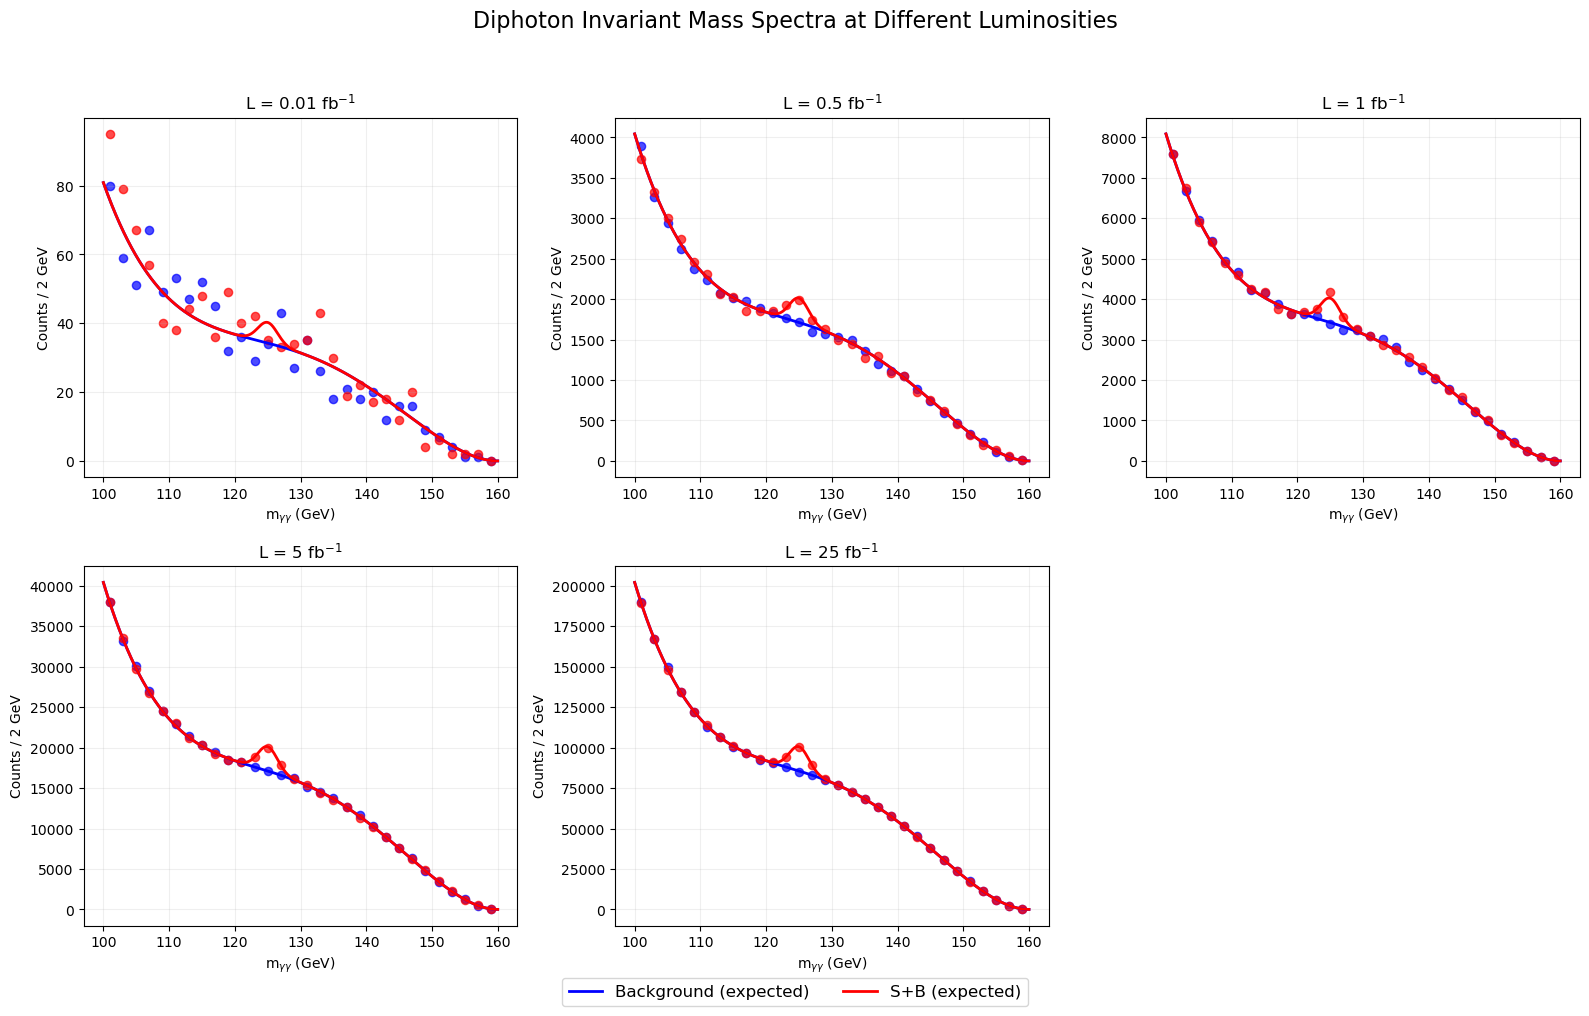

In [27]:
# Create luminosity grid and RNG
luminosities = [0.01, 0.5, 1, 5, 25]
rng = np.random.default_rng(seed=123)

# Create a 2×3 figure grid
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

# Loop over luminosities and fill subplots
for i, L in enumerate(luminosities):
    bg_L, sig_L, tot_L = scale_with_luminosity(L, B_background, S_signal)
    obs_bg, obs_tot = poisson_sample(bg_L, tot_L, rng)

    plot_spectrum_subplot(axes[i], bin_centers, bg_L, sig_L, tot_L, obs_bg, obs_tot, L)

# Hide unused subplot cell
if len(luminosities) < len(axes):
    axes[-1].axis("off")

# One shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,
           loc='upper center',
           bbox_to_anchor=(0.5, 0.02),
           ncol=2,
           fontsize=12)

fig.suptitle("Diphoton Invariant Mass Spectra at Different Luminosities", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.savefig("diphoton_spectra.png", dpi=300, bbox_inches='tight')
plt.show()


## Background-Subtracted Mass Spectrum

To more explicitly reveal the Higgs signal, we subtract the fitted background from each bin:

$$
y_i = O_i - B_i.
$$

This removes the smooth diphoton background, leaving only fluctuations and any real excess near $125~\text{GeV}$.


In [32]:
def plot_background_subtracted_subplot(ax, bin_centers, obs_tot, bg_L, sig_L, L):
    # Data - background
    y = obs_tot - bg_L
    yerr = np.sqrt(obs_tot)

    ax.errorbar(bin_centers, y, yerr=yerr, fmt='o', capsize=3,
                label="Data − background")

    m_fine = np.linspace(m_min, m_max, 2000)
    smooth_sig = L * smooth_signal_curve(m_fine, m_h, sigma, A_signal)
    ax.plot(m_fine, smooth_sig, color='black', linewidth=2,
            label="Expected signal")

    ax.axhline(0, color='black', linewidth=1)

    ax.set_title(f"L = {L} fb$^{{-1}}$")
    ax.set_xlabel(r"$m_{\gamma\gamma}$ (GeV)")
    ax.set_ylabel(r"Counts $-$ background")
    ax.grid(alpha=0.3)


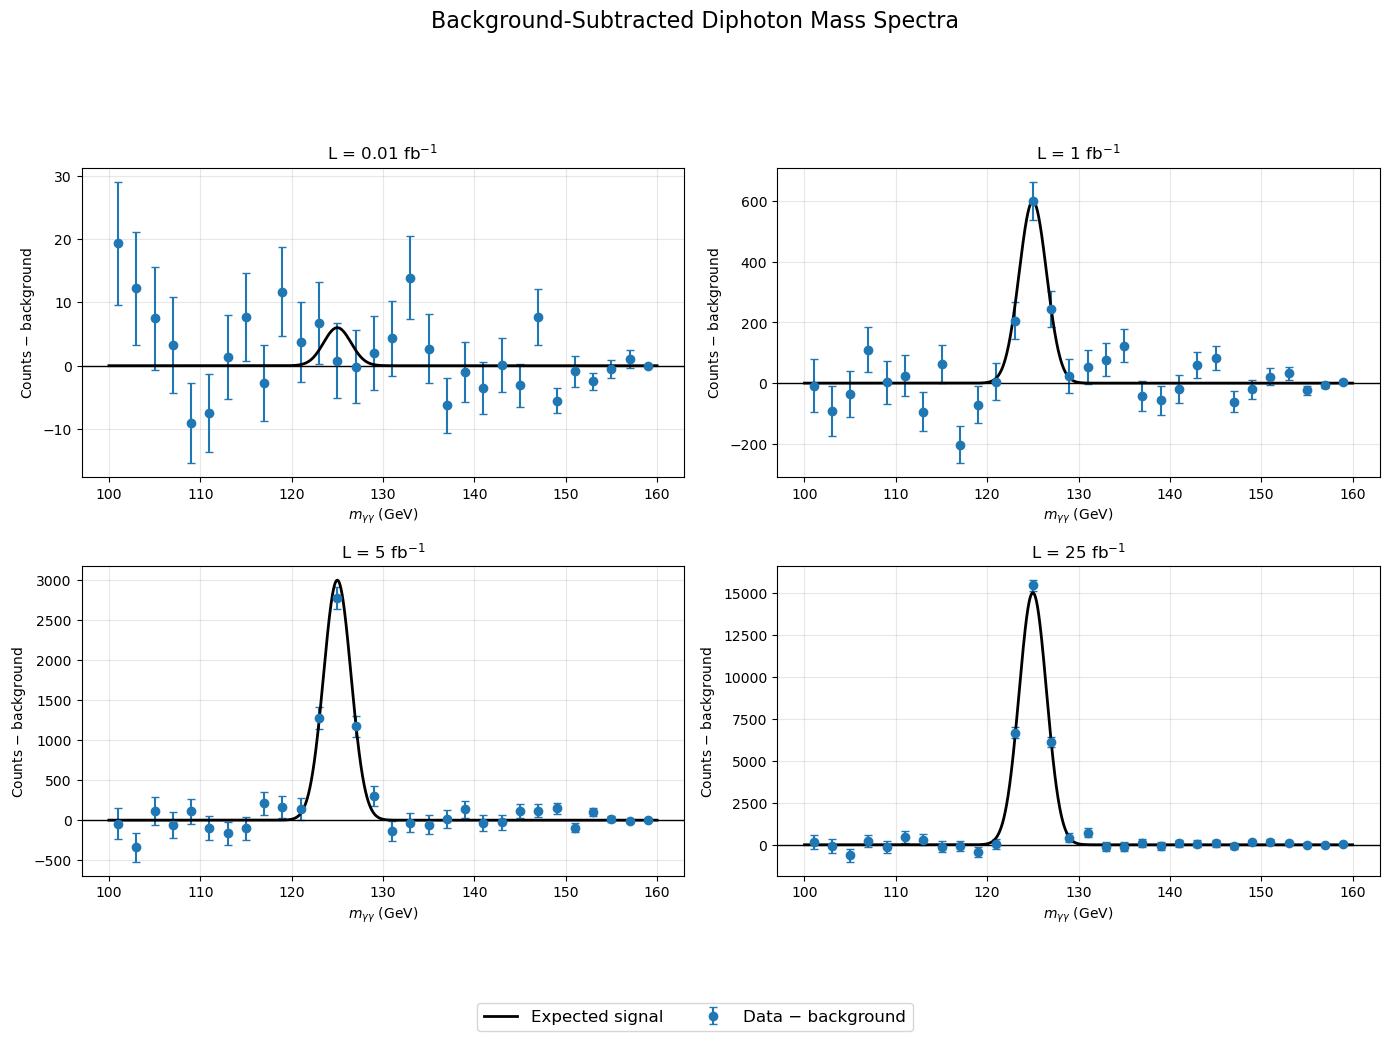

In [35]:
luminosities = [0.01, 1, 5, 25]
rng = np.random.default_rng(seed=123)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, L in enumerate(luminosities):
    bg_L, sig_L, tot_L = scale_with_luminosity(L, B_background, S_signal)
    obs_bg, obs_tot = poisson_sample(bg_L, tot_L, rng)

    plot_background_subtracted_subplot(
        axes[i],
        bin_centers,
        obs_tot,
        bg_L,
        sig_L,
        L
    )

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=2,
    fontsize=12
)

fig.suptitle("Background-Subtracted Diphoton Mass Spectra", fontsize=16)

plt.tight_layout(rect=[0, 0.05, 1, 0.90])
fig.savefig("background_subtracted_panels.png", dpi=300, bbox_inches='tight')

plt.show()



After subtraction, the spectrum sits around zero except for a clear excess near
$m_{\gamma\gamma} \approx 125~\text{GeV}$. This makes the Higgs bump stand out,
similar to how ATLAS presents their diphoton results.

# **Below include some plots to confirm the validity of the synthetic data, including residual plots, poisson error bars, and a visibility/luminosity plot**
# *Residuals Plot (Observed − Expected)*

Residuals measure how far the observed counts differ from the expected model:

$ \text{residual}_i = O_i - \lambda_i $
- If the model is good, residuals should scatter randomly around $0$.
- If a region is mis-modeled (e.g., bad background fit), the residuals show structure.
- A Higgs excess produces positive residuals near $125~\text{GeV}$.

Residuals are one of the most standard diagnostic tools used in validating particle-physics fits.


In [19]:
def plot_residuals(bin_centers, obs_tot, tot_L, L):
    """Residuals = observed − expected."""
    residuals = obs_tot - tot_L

    plt.figure(figsize=(10, 4))
    plt.axhline(0, color='black', linewidth=1)
    plt.scatter(bin_centers, residuals, s=35)
    plt.xlabel("mγγ (GeV)")
    plt.ylabel("Observed − Expected")
    plt.title(f"Residuals Plot (L = {L})")
    plt.grid(alpha=0.3)
    plt.show()


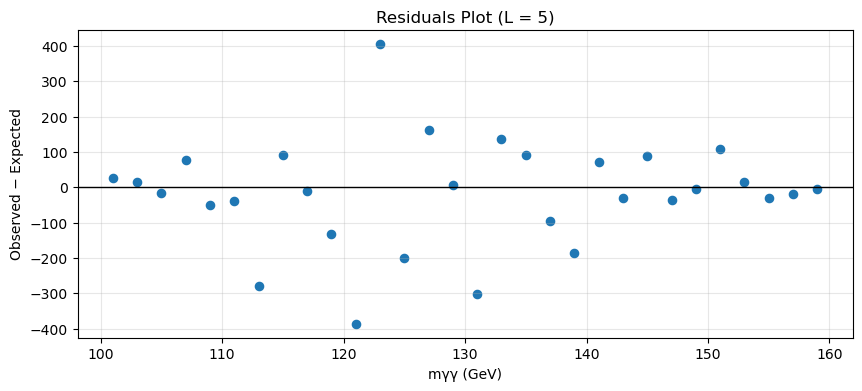

In [25]:
# Example: Residual plot at luminosity L = 20

L = 5

bg_L, sig_L, tot_L = scale_with_luminosity(L, B_background, S_signal)

obs_bg, obs_tot = poisson_sample(bg_L, tot_L, rng)

plot_residuals(bin_centers, obs_tot, tot_L, L)


### **Residuals Summary**

The residuals $O_i - \lambda_i$ fluctuate randomly around zero, as expected
from Poisson statistics. Low-count bins show larger scatter, while high-count
bins are more stable. The lack of any pattern indicates the background + signal
model fits the simulated data well.


### **Observed Counts with Poisson Error Bars**

This plot shows the observed bin counts with statistical uncertainties given by
the Poisson error $\sqrt{n}$. Bins with more events have smaller relative
uncertainties, while low-count bins have larger fluctuations. This visualizes
the expected statistical spread in real diphoton measurements.


In [21]:
def plot_with_poisson_errors(bin_centers, obs_tot, L):
    """Observed counts with sqrt(n) Poisson error bars."""
    errors = np.sqrt(obs_tot)

    plt.figure(figsize=(10, 6))
    plt.errorbar(bin_centers, obs_tot, yerr=errors, fmt='o', capsize=3)
    plt.xlabel(r"$m_{\gamma\gamma}$ (GeV)")
    plt.ylabel("Observed Counts")
    plt.title(f"Observed Counts with Poisson Errors (L = {L})")
    plt.grid(alpha=0.3)
    plt.show()

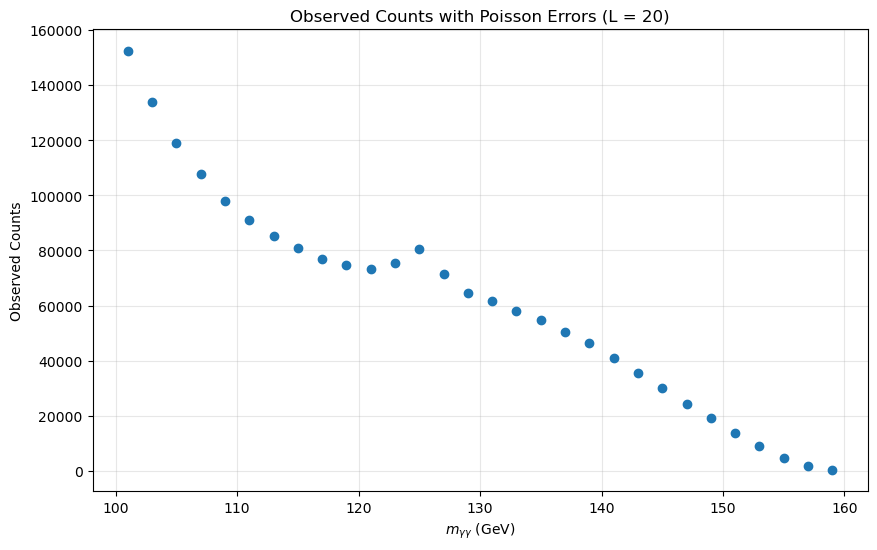

In [22]:
# Example: Poisson error bars at luminosity L = 20

L = 20

bg_L, sig_L, tot_L = scale_with_luminosity(L, B_background, S_signal)

obs_bg, obs_tot = poisson_sample(bg_L, tot_L, rng)

plot_with_poisson_errors(bin_centers, obs_tot, L)


This plot shows the observed counts with Poisson error bars, where each bin’s
uncertainty is $\sqrt{n}$. Higher-count bins have larger errors, lower-count
bins have smaller ones, matching real detector statistics. The downward
trend reflects the diphoton background, and the mild upward fluctuation near
$125\,\text{GeV}$ comes from the Higgs signal.


### Higgs Peak Visibility vs. Luminosity

This plot shows how the **expected** (noise-free) diphoton spectrum  
$
\lambda(m) = B(m) + S(m)
$
changes as we scale the luminosity $L$.

Because event yields grow linearly with $L$, both the falling background and
the Higgs peak increase proportionally. At very low luminosity the Higgs bump
is barely visible, while at high luminosity it becomes a prominent, narrow
feature.


In [23]:
def plot_luminosity_scan(luminosities):
    """Expected signal + background curves for multiple luminosities."""
    m = np.linspace(m_min, m_max, 2000)

    bg = smooth_background_curve(m)
    sig = smooth_signal_curve(m, m_h, sigma, A_signal)

    plt.figure(figsize=(10, 6))

    for L in luminosities:
        tot_L = L * (bg + sig)
        plt.plot(m, tot_L, linewidth=2, label=f"L = {L}")

    plt.xlabel(r"$m_{\gamma\gamma}$ (GeV)")
    plt.ylabel("Expected Counts")
    plt.title("Higgs Peak Visibility vs Luminosity")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


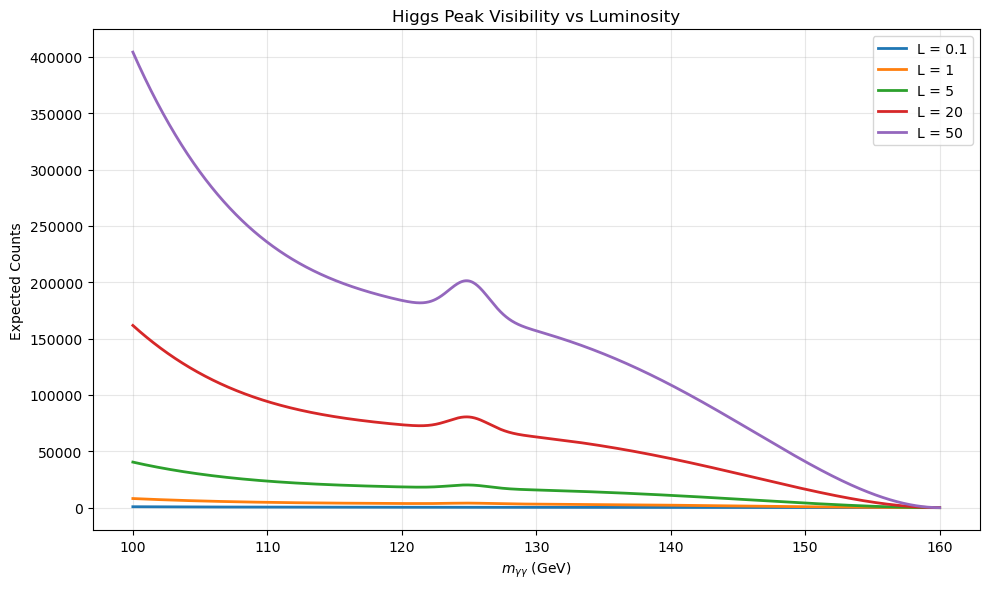

In [24]:
##example 
plot_luminosity_scan([0.1, 1, 5, 20, 50])



**Summary:**  
This figure illustrates how increasing luminosity amplifies both the background
rate and the Higgs resonance. The peak near $m_{\gamma\gamma} \approx 125~\text{GeV}$
becomes progressively more distinct as $L$ grows, mirroring how real ATLAS data
revealed the Higgs: low-$L$ datasets show no clear bump, while high-$L$ datasets
expose a sharp excess above background.


# ***$$\text{Formation for } \texttt{simulate.py}$$***

The file module `simulate.py` provides a complete **Higgs → γγ toy–model simulation pipeline**.  
It generates synthetic diphoton invariant–mass datasets using:

- a **4th-order Bernstein polynomial** to model the smooth falling background,
- a **Gaussian resonance** to represent the Higgs peak,
- **luminosity scaling**
  $$\lambda_i(L) = L\,\lambda_i(1),$$
- **Poisson fluctuations** to mimic detector counting statistics,
  $$n_i \sim \mathrm{Poisson}(\lambda_i),$$
- optional **parameter controls** and **random-seed reproducibility**,  
- standardized **CSV/JSON outputs** for downstream analysis.

This module consolidates the earlier notebook code cells into a single, functional simulation tool that can be imported and used programmatically. 

`simulate.py` also supports **batch generation across multiple luminosities**, allowing every team member to work with consistent pseudo-data for frequentist and Bayesian inference.


In [16]:
from simulate import generate_all_luminosities

generate_all_luminosities([0.1, 1, 5, 20, 100])


Using fitted background coefficients: [4.04271011e+00 2.03969139e-14 3.50781542e+00 1.33383270e-23
 3.43847715e-22]
Saved: dataset_L0.1.csv
Saved: dataset_L1.csv
Saved: dataset_L5.csv
Saved: dataset_L20.csv
Saved: dataset_L100.csv


In [84]:
import pandas as pd
##e.g. csv display for L=20
df = pd.read_csv("dataset_L20.csv")   # replace with any file name
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
df.head()


,mass,expected_background,expected_signal,expected_total,observed_background,observed_total,luminosity
0,101.0,75.710250,1.286105e-54,75.710250,91,95,20
1,103.0,66.805994,9.731633e-46,66.805994,62,62,20
2,105.0,59.544746,1.244561e-37,59.544746,53,55,20
3,107.0,53.697288,2.690093e-30,53.697288,74,54,20
4,109.0,49.049270,9.827419e-24,49.049270,48,53,20


In [ ]:
#!/usr/bin/env python3
# frequentist.py

import numpy as np
from scipy.stats import norm
import pandas as pd

def background_model(x, A=50, b=4):
    return A * np.exp(-b*(x-100))

def signal_model(x, mu, sigma=1.5, S=200):
    return S * np.exp(-(x-mu)**2/(2*sigma**2))

def log_poisson(n, lam):
    from scipy.special import gammaln
    lam = np.maximum(lam, 1e-12)
    return np.sum(n*np.log(lam) - lam - gammaln(n+1))

def scan_masses(x, n):
    mus = np.linspace(110, 150, 80)
    q = []

    bg = background_model(x)
    ll_bg = log_poisson(n, bg)  # compute once outside the loop

    for mu in mus:
        lam_s = bg + signal_model(x, mu)
        ll_s = log_poisson(n, lam_s)
        q.append(2*(ll_s - ll_bg))

    q = np.array(q)
    q[q < 0] = 0
    return mus, q

def get_global_significance(q_values, trials=80):
    local_Z = np.sqrt(np.max(q_values))
    global_Z = max(local_Z - 1.0, 0)
    return local_Z, global_Z

if __name__ == "__main__":
    # Prompt the user to enter the filename
    filename = input("Enter the CSV filename (e.g., dataset_L1.csv): ").strip()
    
    try:
        df = pd.read_csv(filename)
    except FileNotFoundError:
        print(f"File not found: {filename}")
        exit(1)

    x = df["mass"].values
    n = df["observed_total"].values
    
    mus, q_values = scan_masses(x, n)
    local_Z, global_Z = get_global_significance(q_values)

    print("Local significance:", local_Z)
    print("Global significance:", global_Z)



In [1]:
{"id":"61298","variant":"standard","title":"bayesian_with_graphs_and_input"}
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dynesty import NestedSampler
from scipy.special import gammaln

# -----------------------------
# Models
# -----------------------------
def background_model(x, A, b):
    return A * np.exp(-b * (x - 100))

def signal_plus_background(x, A, b, mu, S):
    bg = background_model(x, A, b)
    sig = S * np.exp(-(x - mu)**2 / (2 * 1.5**2))
    return bg + sig

# -----------------------------
# Log-likelihood
# -----------------------------
def log_poisson(n, lam):
    lam = np.maximum(lam, 1e-12)
    return np.sum(n*np.log(lam) - lam - gammaln(n+1))

# -----------------------------
# Priors
# -----------------------------
def prior_B(u):
    A = 10 + 500 * u[0]
    b = 1 + 5 * u[1]
    return A, b

def prior_SB(u):
    A = 10 + 500 * u[0]
    b = 1 + 5 * u[1]
    mu = 110 + 40 * u[2]
    S = 500 * u[3]
    return A, b, mu, S

# -----------------------------
# Likelihood wrappers
# -----------------------------
def make_loglike_B(x, n):
    def loglike(theta):
        A, b = theta
        lam = background_model(x, A, b)
        return log_poisson(n, lam)
    return loglike

def make_loglike_SB(x, n):
    def loglike(theta):
        A, b, mu, S = theta
        lam = signal_plus_background(x, A, b, mu, S)
        return log_poisson(n, lam)
    return loglike

# -----------------------------
# Run Bayesian analysis
# -----------------------------
def run_bayes(file, maxiter_B=2000, maxiter_SB=4000):
    df = pd.read_csv(file)
    x = df["mass"].values
    n = df["observed_total"].values

    # Background-only model
    sampler_B = NestedSampler(make_loglike_B(x, n), prior_B, ndim=2)
    sampler_B.run_nested(maxiter=maxiter_B)
    ZB = sampler_B.results.logz[-1]
    samples_B = sampler_B.results.samples

    # Signal + background model
    sampler_SB = NestedSampler(make_loglike_SB(x, n), prior_SB, ndim=4)
    sampler_SB.run_nested(maxiter=maxiter_SB)
    ZSB = sampler_SB.results.logz[-1]
    samples_SB = sampler_SB.results.samples

    # Posterior probability of background-only
    posterior_prob_B = 1.0 / (1.0 + np.exp(ZSB - ZB))

    return {
        "logZ_B": ZB,
        "logZ_SB": ZSB,
        "posterior_p(B)": posterior_prob_B,
        "x": x,
        "n": n,
        "samples_B": samples_B,
        "samples_SB": samples_SB
    }

# -----------------------------
# Plotting
# -----------------------------
def plot_results(result):
    x = result["x"]
    n = result["n"]

    # Fitted background (median)
    A_median, b_median = np.median(result["samples_B"], axis=0)
    bg_fit = background_model(x, A_median, b_median)

    # Fitted signal+background (median)
    A_m, b_m, mu_m, S_m = np.median(result["samples_SB"], axis=0)
    sb_fit = signal_plus_background(x, A_m, b_m, mu_m, S_m)

    plt.figure(figsize=(10,6))
    plt.errorbar(x, n, yerr=np.sqrt(n), fmt='o', label='Observed')
    plt.plot(x, bg_fit, 'r--', label='Background fit (median)')
    plt.plot(x, sb_fit, 'g-', label='Signal+Background fit (median)')
    plt.xlabel("Mass")
    plt.ylabel("Counts")
    plt.title("Bayesian Fit")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Posterior distributions
    samples_B = result["samples_B"]
    samples_SB = result["samples_SB"]

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.hist(samples_B[:,0], bins=30, alpha=0.6)
    plt.xlabel("A (background amplitude)")
    plt.ylabel("Posterior counts")
    plt.title("Background-only posterior")

    plt.subplot(1,2,2)
    plt.hist(samples_B[:,1], bins=30, alpha=0.6)
    plt.xlabel("b (background slope)")
    plt.ylabel("Posterior counts")
    plt.title("Background-only posterior")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,8))
    labels = ["A","b","mu","S"]
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.hist(samples_SB[:,i], bins=30, alpha=0.6)
        plt.xlabel(labels[i])
        plt.ylabel("Posterior counts")
        plt.title(f"Signal+Background posterior: {labels[i]}")
    plt.tight_layout()
    plt.show()

# -----------------------------
# CLI
# -----------------------------
if __name__ == "__main__":
    filename = input("Enter the CSV filename (e.g., dataset_L1.csv): ").strip()
    try:
        result = run_bayes(filename)
    except FileNotFoundError:
        print(f"File not found: {filename}")
        exit(1)

    print(f"LogZ B: {result['logZ_B']:.2f}")
    print(f"LogZ SB: {result['logZ_SB']:.2f}")
    print(f"Posterior P(B|data): {result['posterior_p(B)']:.3f}")

    plot_results(result)



ModuleNotFoundError: No module named 'dynesty'

In [ ]:
Plots

In [ ]:
# plots.py
import numpy as np
import matplotlib.pyplot as plt
from frequentist import scan_masses
import pandas as pd

# -----------------------------
# Plot the observed data
# -----------------------------

def plot_data(file):
    df = pd.read_csv(file)
    x = df["mass"].values
    n = df["observed_total"].values

    plt.figure(figsize=(7, 5))
    plt.step(x, n, where="mid")
    plt.xlabel("mγγ")
    plt.ylabel("Counts")
    plt.title(f"Observed Data: {file}")
    plt.tight_layout()
    plt.show()


# -----------------------------
# Plot the likelihood-ratio scan q(μ)
# -----------------------------

def plot_qscan(file):
    df = pd.read_csv(file)
    x = df["mass"].values
    n = df["observed_total"].values

    mus, q = scan_masses(x, n)

    plt.figure(figsize=(7, 5))
    plt.plot(mus, q)
    plt.xlabel("Mass hypothesis μ")
    plt.ylabel("q(μ)")
    plt.title(f"Likelihood Ratio Scan: {file}")
    plt.tight_layout()
    plt.show()


# -----------------------------
# CLI
# -----------------------------

if __name__ == "__main__":
    plot_data("dataset_L10.csv")
    plot_qscan("dataset_L10.csv")

